In [23]:
import sympy as sp
from lbmpy.stencils import LBStencil, Stencil
from lbmpy.moments import MOMENT_SYMBOLS, moment_matrix
import numpy as np
from sympy.plotting import plot

# Direct application of what I think is happening in gross 2010 paper

In [24]:
B = sp.symbols("beta")
rho0, rho, rho_v, rho_l = sp.symbols("rho_0 rho rho_v rho_l")
f0 = B*((rho - rho_v)**2)*((rho - rho_l)**2)
cs = sp.symbols("c_s")

mu0 = sp.Derivative(f0, rho).doit()
p0 = sp.simplify(rho*mu0 - f0)
p0

beta*(rho - rho_l)*(rho - rho_v)*(2*rho*(2*rho - rho_l - rho_v) - (rho - rho_l)*(rho - rho_v))

In [25]:
spinodal_line = sp.Derivative(f0, rho, 2).doit()
rhov_real = 0.1
rhol_real = 1.1
beta_real = 0.04
phase_line = sp.simplify(spinodal_line.subs({rho_v:rhov_real, rho_l:rhol_real, B:beta_real}))

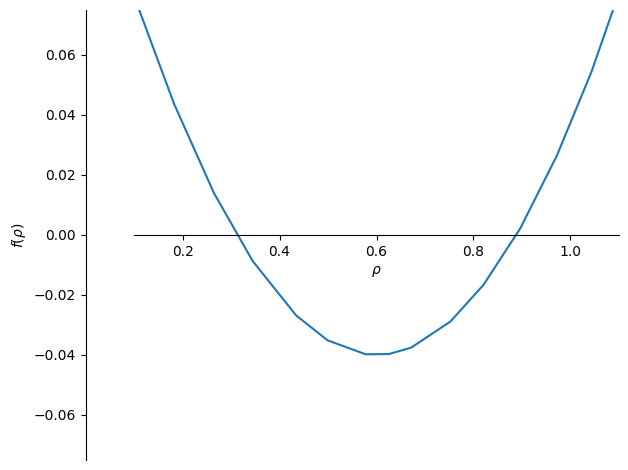

In [26]:
plot(phase_line, xlim = [rhov_real, rhol_real], ylim = [-0.075, 0.075])

## Moment matrix

In [27]:
d3q19 = LBStencil(Stencil.D3Q19)
D = len(d3q19[0])
Q = len(d3q19)
c = sp.Matrix(d3q19)

x, y, z = MOMENT_SYMBOLS
one = sp.core.sympify(1)
c2 = x**2+y**2+z**2
c4 = c2**2

moments = [ 
    one,
    x,
    y,
    z,
    c2-1,
    3*x**2-c2,
    y**2-z**2,
    x*y,
    y*z,
    z*x,
    (3*c2-5)*x,
    (3*c2-5)*y,
    (3*c2-5)*z,
    (y**2-z**2)*x,
    (z**2-x**2)*y,
    (x**2-y**2)*z,
    3*c4-6*c2+1,
    (2*c2-3)*(3*x**2-c2),
    (2*c2-3)*(y**2-z**2)
]

M = moment_matrix(moments, stencil=d3q19)
N = [ sum([w[i]*M[a,i]**2 for i in range (Q)]) for a in range(Q) ]

## Moment and equilibrium distribution calculation

In [6]:
kappa = sp.symbols('kappa')
pb = sp.symbols('p_b')
rho = sp.symbols('rho',cls=sp.Function)(x,y,z)
ux, uy, uz = sp.symbols('u_x, u_y, u_z')
cs = sp.sqrt(sp.Rational(1,3))
kx, ky, kz = sp.symbols('k_x, k_y, k_z')
ks = {x:kx,y:ky,z:kz}
u = sp.Matrix([ux,uy,uz])
Drho2 = sp.Matrix([ [ sp.Derivative(rho,a)*sp.Derivative(rho,b) for b in [x,y,z] ] for a in [x,y,z] ])
D2rho = sum([ sp.Derivative(rho,a,2) for a in [x,y,z] ])
G = kappa*Drho2

five36 = sp.Rational(5,36)
one9 = sp.Rational(1,9)
one12 = sp.Rational(1,12)
one36 = sp.Rational(1,36)
one72 = sp.Rational(1,72)

w = [ sp.Rational(1,3) ] + [ sp.Rational(1,18) ]*6 + [ sp.Rational(1,36) ]*12

ww =  [ [[0]*3]*3 ] \
    + [ [ [ -one9, 0, 0], [0, five36, 0], [0, 0,  -one9] ] ]*2 \
    + [ [ [five36, 0, 0], [0,  -one9, 0], [0, 0,  -one9] ] ]*2 \
    + [ [ [ -one9, 0, 0], [0,  -one9, 0], [0, 0, five36] ] ]*2 \
    + [ [ [-one72, -one12, 0], [ -one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72,  one12, 0], [  one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72,  one12, 0], [  one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72, -one12, 0], [ -one12, -one72, 0], [ 0, 0, one36] ],
        [ [ one36, 0, 0], [ 0, -one72,  one12], [ 0,  one12, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72, -one12], [ 0, -one12, -one72] ],
        [ [-one72, 0, -one12], [ 0, one36, 0], [ -one12, 0, -one72] ],
        [ [-one72, 0,  one12], [ 0, one36, 0], [  one12, 0, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72, -one12], [ 0, -one12, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72,  one12], [ 0,  one12, -one72] ],
        [ [-one72, 0,  one12], [ 0, one36, 0], [  one12, 0, -one72] ],
        [ [-one72, 0, -one12], [ 0, one36, 0], [ -one12, 0, -one72] ] ]

def f(i):
    f = w[i]/cs**2*pb \
        + w[i]/cs**2*rho*c[i,:].dot(u) \
        + w[i]/(2*cs**4)*rho*u.dot((c[i,:].T@c[i,:]-cs**2*sp.eye(D))@u) \
        - w[i]/cs**2*(kappa*rho*D2rho) \
        + sum([ ww[i][j][j]/cs**2*G[j,j] for j in range(D) ]) \
        + sum([ ww[i][j][(j+1)%D]/cs**2*G[j,(j+1)%D] for j in range(D) ])
    return f

feq = sp.Matrix([ f(i) for i in range(0,Q) ])
feq[0] = rho - sum(feq[1:])
feq.simplify()
mf = sp.simplify(M*feq)
mf

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                              rho(x, y, z)],
[                                                                                                                                                                                                                                                                                                                                                                          u_x*rho(x, y, z)],
[                                                                                                                                                                                                                                  

In [7]:
Drho2

Matrix([
[                         Derivative(rho(x, y, z), x)**2, Derivative(rho(x, y, z), x)*Derivative(rho(x, y, z), y), Derivative(rho(x, y, z), x)*Derivative(rho(x, y, z), z)],
[Derivative(rho(x, y, z), x)*Derivative(rho(x, y, z), y),                          Derivative(rho(x, y, z), y)**2, Derivative(rho(x, y, z), y)*Derivative(rho(x, y, z), z)],
[Derivative(rho(x, y, z), x)*Derivative(rho(x, y, z), z), Derivative(rho(x, y, z), y)*Derivative(rho(x, y, z), z),                          Derivative(rho(x, y, z), z)**2]])

In [8]:
D2rho

Derivative(rho(x, y, z), (x, 2)) + Derivative(rho(x, y, z), (y, 2)) + Derivative(rho(x, y, z), (z, 2))

## Calculation of noise covariance matrix

In [9]:
kappa = sp.symbols('kappa')
pb = sp.symbols('p_b')
rho = sp.symbols('rho',cls=sp.Function)(x,y,z)
ux, uy, uz = sp.symbols('u_x, u_y, u_z')
k, kx, ky, kz = sp.symbols('k, k_x, k_y, k_z')
# k = sp.symbols('k')
ks = {x:kx,y:ky,z:kz}
u = sp.Matrix([ux,uy,uz])
Drho2 = sp.Matrix([ [ 0 for b in [x,y,z] ] for a in [x,y,z] ])
D2rho = -k**2*rho
G = kappa*Drho2
cs = sp.sqrt(sp.Rational(1, 3))
five36 = sp.Rational(5,36)
one9 = sp.Rational(1,9)
one12 = sp.Rational(1,12)
one36 = sp.Rational(1,36)
one72 = sp.Rational(1,72)

w = [ sp.Rational(1,3) ] + [ sp.Rational(1,18) ]*6 + [ sp.Rational(1,36) ]*12

ww =  [ [[0]*3]*3 ] \
    + [ [ [ -one9, 0, 0], [0, five36, 0], [0, 0,  -one9] ] ]*2 \
    + [ [ [five36, 0, 0], [0,  -one9, 0], [0, 0,  -one9] ] ]*2 \
    + [ [ [ -one9, 0, 0], [0,  -one9, 0], [0, 0, five36] ] ]*2 \
    + [ [ [-one72, -one12, 0], [ -one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72,  one12, 0], [  one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72,  one12, 0], [  one12, -one72, 0], [ 0, 0, one36] ],
        [ [-one72, -one12, 0], [ -one12, -one72, 0], [ 0, 0, one36] ],
        [ [ one36, 0, 0], [ 0, -one72,  one12], [ 0,  one12, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72, -one12], [ 0, -one12, -one72] ],
        [ [-one72, 0, -one12], [ 0, one36, 0], [ -one12, 0, -one72] ],
        [ [-one72, 0,  one12], [ 0, one36, 0], [  one12, 0, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72, -one12], [ 0, -one12, -one72] ],
        [ [ one36, 0, 0], [ 0, -one72,  one12], [ 0,  one12, -one72] ],
        [ [-one72, 0,  one12], [ 0, one36, 0], [  one12, 0, -one72] ],
        [ [-one72, 0, -one12], [ 0, one36, 0], [ -one12, 0, -one72] ] ]

def f(i):
    f = w[i]/cs**2*pb \
        + w[i]/cs**2*rho*c[i,:].dot(u) \
        + w[i]/(2*cs**4)*rho*u.dot((c[i,:].T@c[i,:]-cs**2*sp.eye(D))@u) \
        - w[i]/cs**2*(kappa*rho*D2rho) \
        + sum([ ww[i][j][j]/cs**2*G[j,j] for j in range(D) ]) \
        + sum([ ww[i][j][(j+1)%D]/cs**2*G[j,(j+1)%D] for j in range(D) ])
    return f

feq = sp.Matrix([ f(i) for i in range(0,Q) ])
feq[0] = rho - sum(feq[1:])
feq.simplify()
mf = sp.simplify(M*feq)
mf

Matrix([
[                                                                                                         rho(x, y, z)],
[                                                                                                     u_x*rho(x, y, z)],
[                                                                                                     u_y*rho(x, y, z)],
[                                                                                                     u_z*rho(x, y, z)],
[3*k**2*kappa*rho(x, y, z)**2 + 3*p_b + u_x**2*rho(x, y, z) + u_y**2*rho(x, y, z) + u_z**2*rho(x, y, z) - rho(x, y, z)],
[                                                                            (2*u_x**2 - u_y**2 - u_z**2)*rho(x, y, z)],
[                                                                                       (u_y**2 - u_z**2)*rho(x, y, z)],
[                                                                                                 u_x*u_y*rho(x, y, z)],
[                      

In [10]:
rho0 = sp.symbols("rho0")
k = sp.symbols('k')
cs = sp.symbols('c_s', real=True, cls=sp.Function)(k)

fbar = feq.subs({pb:rho*cs**2}).subs({rho:rho0,ux:0,uy:0,uz:0,kappa:0})
S = sp.symbols('S', cls=sp.Function)(k)/rho0*sp.diag(*fbar)
G = sp.simplify(M@S@M.T)
G

Matrix([
[                  S(k),              0,              0,              0, (3*c_s(k)**2 - 1)*S(k),                0,                  0,                0,                0,                0,                0,                0,                0,                  0,                  0,                  0, (1 - 3*c_s(k)**2)*S(k),                0,                  0],
[                     0, S(k)*c_s(k)**2,              0,              0,                      0,                0,                  0,                0,                0,                0,                0,                0,                0,                  0,                  0,                  0,                      0,                0,                  0],
[                     0,              0, S(k)*c_s(k)**2,              0,                      0,                0,                  0,                0,                0,                0,                0,                0,                0,                 

In [11]:
# lb,ls,lq,le = sp.symbols('lambda_b, lambda_s, lambda_q, lambda_e', real = True)
# lambdas = [0]*4 + [lb]*1 + [ls]*5 + [lq]*6 + [lb]*3
d = 3*(cs**2 - sp.Rational(1,3))
l = sp.symbols("lambda")
lambdas = [0]*4 + [l]*1 + [l]*5 + [l]*6 + [l]*3
Lambda = sp.diag(*lambdas)

Lambda[4,0] = -d*lambdas[4]
Lambda[16,0] = d*lambdas[16]

Lambda

Matrix([
[                       0, 0, 0, 0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[                       0, 0, 0, 0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[                       0, 0, 0, 0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[                       0, 0, 0, 0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[lambda*(1 - 3*c_s(k)**2), 0, 0, 0, lambda,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[                       0, 0, 0, 0,      0, lambda,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0,      0],
[                       0, 0, 0, 0,      0,      

In [13]:
A = Lambda # Advection matrix A

Xi = sp.simplify(A@G + G@A.T)
# Xi = Xi/sp.Rational(1, 3)
Xi

Matrix([
[0, 0, 0, 0,                                         0,                       0,                         0,                         0,                         0,                         0,                       0,                       0,                       0,                         0,                         0,                         0,                                         0,                       0,                         0],
[0, 0, 0, 0,                                         0,                       0,                         0,                         0,                         0,                         0,                       0,                       0,                       0,                         0,                         0,                         0,                                         0,                       0,                         0],
[0, 0, 0, 0,                                         0,                       0,                         0,  

In [129]:
idx = 7
Xi.diagonal()[idx]

2*lambda*S(k)*c_s(k)**2/3

In [130]:
N[idx]

1/9

In [131]:
Xi.diagonal()[idx]/N[idx]

6*lambda*S(k)*c_s(k)**2

# Comparing actual versus theoretical values

In [115]:
import yt
import matplotlib.pyplot as plt

In [153]:
ts = yt.load("hydro_plt*")
L = 16
conserved_variables = [('boxlib', 'rho'), ('boxlib', 'ux'), ('boxlib', 'uy'), ('boxlib', 'uz'),
                       ('boxlib', 'pxx'), ('boxlib', 'pyy'), ('boxlib', 'pzz'),
                       ('boxlib', 'pxy'), ('boxlib', 'pxz'), ('boxlib', 'pyz')]
conserved_variables_data = np.zeros((len(conserved_variables), len(ts[1:]), L**3))

for i in range(1, len(ts)):
    ds = ts[i]
    ad = ds.all_data()

    for j, label in enumerate(conserved_variables):
        conserved_variables_data[j, i - 1] = ad[label] 

yt : [INFO     ] 2024-07-02 14:40:55,984 Parameters: current_time              = 100.0
yt : [INFO     ] 2024-07-02 14:40:55,985 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-07-02 14:40:55,985 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-07-02 14:40:55,986 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-07-02 14:40:56,099 Parameters: current_time              = 200.0
yt : [INFO     ] 2024-07-02 14:40:56,100 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-07-02 14:40:56,100 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-07-02 14:40:56,102 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-07-02 14:40:56,210 Parameters: current_time              = 300.0
yt : [INFO     ] 2024-07-02 14:40:56,211 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-07-02 14:40:56,212 Parameters: domain_left_edge          = [0. 0. 0.]
yt 

From G matrix above, the theoretical value of the variance of the noise can be calculated. The mean of the expected distribution for these variables are as the reference density and velocities, $\rho_0 = 1$, $u_x = u_y = u_z = 0$

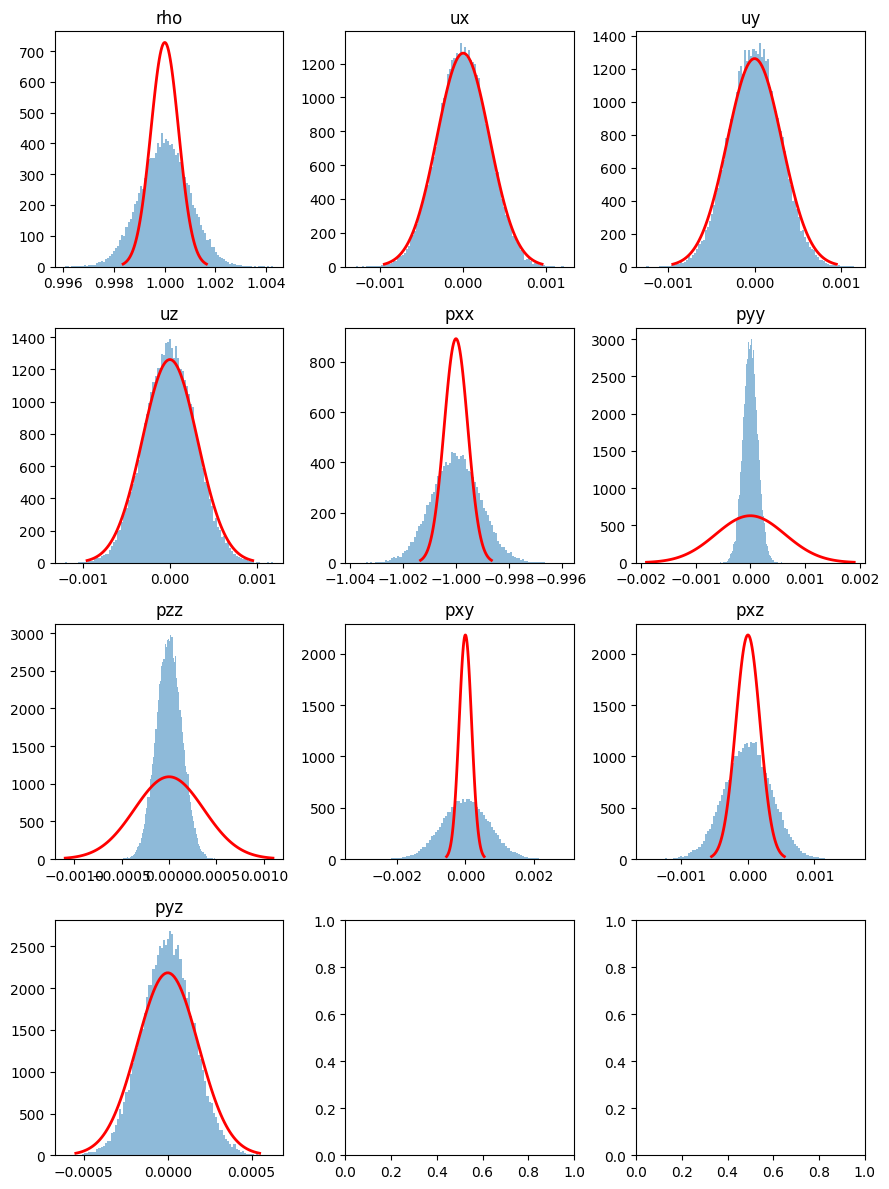

In [154]:
import scipy.stats as stats

fig, axs = plt.subplots(4, 3, figsize = (3*3, 4*3))

kbt = 1e-7
rho0 = 1
u0 = 0
cs2 = 1/3

s_k =  kbt*rho0/cs2
mu_s = [rho0, u0, u0, u0]
mu_s = [rho0] + [u0]*3 + [-1] + 5*[0]

variances = [s_k] + [s_k*cs2]*3 +  [(1 - cs2)*s_k] + [4*s_k*cs2] + [4/3*s_k*cs2] + 3*[1/3*s_k*cs2]
# variances = [s_k, s_k*cs2, s_k*cs2, s_k*cs2, (1 - cs2)*s_k, 4*s_k*cs2, 4/3*s_k*cs2, 1/3*s_k*cs2]

axs = axs.flatten()

for i in range(len(conserved_variables)):
    ax = axs[i]
    ax.hist(conserved_variables_data[i, ...].flatten(), bins = 100, 
            density = True, color = 'tab:blue', alpha = 0.5)

    mu = mu_s[i]
    sigma = np.sqrt(variances[i])
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), color = 'red', lw = 2)

    ax.set_title(conserved_variables[i][-1])

fig.tight_layout()